# Enefit - Predict Energy Behavior of Prosumers | MODEL

<img src="./header.png" width="1200" height="400"/>

## 1. Import ncessary libraries 

In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import warnings
from tqdm.notebook import tqdm_notebook
from concurrent.futures import ProcessPoolExecutor

pool_executor = ProcessPoolExecutor()

plt.style.use("ggplot")
plt.rcParams["font.size"] = 15

COLORS = list(sns.color_palette("husl", 8))

warnings.filterwarnings('ignore')

In [2]:
INPUT_DIR = '../../../Kaggle_input/input/Enefit-Predict-Energy-Behavior/predict-energy-behavior-of-prosumers/'

In [3]:
os.listdir(INPUT_DIR)

['county_id_to_name_map.json',
 'client.csv',
 'example_test_files',
 'train_merged.pkl',
 'enefit',
 'weather_station_to_county_mapping.csv',
 'train.csv',
 'public_timeseries_testing_util.py',
 'gas_prices.csv',
 'historical_weather.csv',
 'forecast_weather.csv',
 'electricity_prices.csv']

## 2. Import Processed Data 

In [4]:
train = pd.read_pickle(f"{INPUT_DIR}/train_merged.pkl")

In [5]:
train.head()

,county,is_business,product_type,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,...,surface_pressure,cloudcover_total_hw,cloudcover_low_hw,cloudcover_mid_hw,cloudcover_high_hw,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation_hw,diffuse_radiation
0,0,0,1,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,...,1008.433333,58.833333,61.500000,4.166667,3.833333,4.972222,340.000000,0.0,0.0,0.0
1,0,0,1,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,...,1008.433333,58.833333,61.500000,4.166667,3.833333,4.972222,340.000000,0.0,0.0,0.0
2,0,0,1,0,2021-09-01 01:00:00,0,122,0,2021-09-01,01:00:00,...,1008.350000,32.333333,29.666667,1.166667,15.833333,5.069444,344.833333,0.0,0.0,0.0
3,0,0,1,1,2021-09-01 01:00:00,0,123,0,2021-09-01,01:00:00,...,1008.350000,32.333333,29.666667,1.166667,15.833333,5.069444,344.833333,0.0,0.0,0.0
4,0,0,1,0,2021-09-01 02:00:00,0,244,0,2021-09-01,02:00:00,...,1008.000000,16.500000,17.166667,0.166667,3.000000,4.907407,340.666667,0.0,0.0,0.0


In [6]:
train.dtypes

county                                        int64
is_business                                   int64
product_type                                  int64
is_consumption                                int64
datetime                             datetime64[ns]
data_block_id                                 int64
row_id                                        int64
prediction_unit_id                            int64
date                                 datetime64[ns]
time                                         object
target                                      float64
eic_count                                   float64
installed_capacity                          float64
lowest_price_per_mwh                        float64
highest_price_per_mwh                       float64
euros_per_mwh                               float64
temperature                                 float64
dewpoint                                    float64
cloudcover_high                             float64
cloudcover_l

In [7]:
train.drop(columns=["time", "data_block_id_fw", "data_block_id"], inplace=True)

In [8]:
train.shape

(2018352, 42)

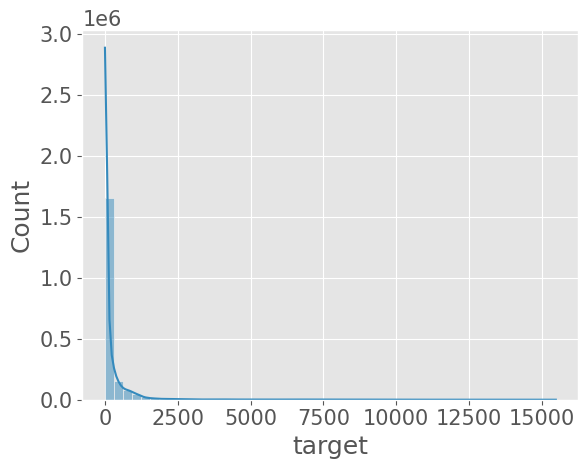

In [9]:
# train["target"] = train["target"]
sns.histplot(train['target'], bins=50, kde=True, )
plt.show()

In [10]:
train.row_id.duplicated().value_counts()

False    2018352
Name: row_id, dtype: int64

In [11]:
train.set_index("row_id", inplace=True)

## 3. Creating Time Features 

In [12]:
train["day"] = train.date.dt.day
train["month"] = train.date.dt.month
train["year"] = train.date.dt.year
train["day_of_week"] = train.date.dt.dayofweek
train["day_of_year"] = train.date.dt.dayofyear
train["week_of_year"] = train.date.dt.isocalendar().week.astype(int)
train["date_index"] = train.date.factorize()[0]
train["hour_of_day"] = train.datetime.dt.hour


In [13]:
train.isna().sum()

county                               0
is_business                          0
product_type                         0
is_consumption                       0
datetime                             0
prediction_unit_id                   0
date                                 0
target                               0
eic_count                            0
installed_capacity                   0
lowest_price_per_mwh                 0
highest_price_per_mwh                0
euros_per_mwh                        0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
direct_solar_radiation               0
surface_solar_radiation_downwards    0
snowfall                             0
total_precipitation                  0
latitude                 

In [14]:
df_prod = train[train.is_consumption.eq(0)]
df_prod.head()

,county,is_business,product_type,is_consumption,datetime,prediction_unit_id,date,target,eic_count,installed_capacity,...,direct_solar_radiation_hw,diffuse_radiation,day,month,year,day_of_week,day_of_year,week_of_year,date_index,hour_of_day
row_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,2021-09-01 00:00:00,0,2021-09-01,0.713,108.0,952.89,...,0.0,0.0,1,9,2021,2,244,35,0,0
122,0,0,1,0,2021-09-01 01:00:00,0,2021-09-01,1.132,108.0,952.89,...,0.0,0.0,1,9,2021,2,244,35,0,1
244,0,0,1,0,2021-09-01 02:00:00,0,2021-09-01,0.490,108.0,952.89,...,0.0,0.0,1,9,2021,2,244,35,0,2
366,0,0,1,0,2021-09-01 03:00:00,0,2021-09-01,0.496,108.0,952.89,...,0.0,0.0,1,9,2021,2,244,35,0,3
488,0,0,1,0,2021-09-01 04:00:00,0,2021-09-01,0.149,108.0,952.89,...,0.0,0.0,1,9,2021,2,244,35,0,4


In [15]:
df_con = train[train.is_consumption.eq(1)]
df_con.head()

,county,is_business,product_type,is_consumption,datetime,prediction_unit_id,date,target,eic_count,installed_capacity,...,direct_solar_radiation_hw,diffuse_radiation,day,month,year,day_of_week,day_of_year,week_of_year,date_index,hour_of_day
row_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,2021-09-01 00:00:00,0,2021-09-01,96.590,108.0,952.89,...,0.0,0.0,1,9,2021,2,244,35,0,0
123,0,0,1,1,2021-09-01 01:00:00,0,2021-09-01,77.691,108.0,952.89,...,0.0,0.0,1,9,2021,2,244,35,0,1
245,0,0,1,1,2021-09-01 02:00:00,0,2021-09-01,91.594,108.0,952.89,...,0.0,0.0,1,9,2021,2,244,35,0,2
367,0,0,1,1,2021-09-01 03:00:00,0,2021-09-01,87.955,108.0,952.89,...,0.0,0.0,1,9,2021,2,244,35,0,3
489,0,0,1,1,2021-09-01 04:00:00,0,2021-09-01,88.184,108.0,952.89,...,0.0,0.0,1,9,2021,2,244,35,0,4


## 4. Modeling 

In [16]:
def model_training(model_name, df, model):
    # We will first separate the target variable from the features
    y = np.log1p(df['target'])
    x = df.drop(columns=['target'])

    train_len = math.ceil(x.shape[0] * 0.9)
    valid_len = x.shape[0] - train_len

    train_x = x.iloc[:train_len]
    train_y = y.iloc[:train_len]

    valid_x = x.iloc[train_len:]
    valid_y = y.iloc[train_len:]


    model.fit(train_x, train_y)
    preds_valid = model.predict(valid_x)
    preds_train = model.predict(train_x)

    # results
    score_train = mean_absolute_error(np.expm1(train_y), np.expm1(preds_train))
    score_valid = mean_absolute_error(np.expm1(valid_y), np.expm1(preds_valid))

    print(f"MAE Train for {model_name}: {score_train}")
    print(f"MAE Validation for {model_name}: {score_valid}")
    
    print(model.get_params())

### 4.1 Base Model: Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
df = train.drop(columns=["datetime", "date", "latitude", "longitude", ])
model_training("Linear Regression", df, LinearRegression())

MAE Train for Linear Regression: 230.79031115361653
MAE Validation for Linear Regression: 627.2047007351034
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}


### 4.2 XGBRegressor 

In [18]:
import xgboost as xgb
model_training("XGB Regressor", df, xgb.XGBRegressor(random_state=42))

MAE Train for XGB Regressor: 43.00084779674223
MAE Validation for XGB Regressor: 95.91630991663327
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


### 4.3 LGBMRegressor 

In [19]:
import lightgbm as lgb
model_training("LGBM Regressor", df, lgb.LGBMRegressor(random_state=42))

MAE Train for LGBM Regressor: 56.95978169016006
MAE Validation for LGBM Regressor: 105.15735724888924
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


### Let's try modeling on Consupmtion and Production datasets separately.

> XGB Regressor

In [20]:
model_training("XGB Regressor", df_prod.drop(columns=["datetime", "date", "latitude", "longitude", ]), xgb.XGBRegressor(random_state=42))

MAE Train for XGB Regressor: 14.64494870533999
MAE Validation for XGB Regressor: 83.05384203764476
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [21]:
model_training("XGB Regressor", df_con.drop(columns=["datetime", "date", "latitude", "longitude", ]), xgb.XGBRegressor(random_state=42))

MAE Train for XGB Regressor: 53.833281812689215
MAE Validation for XGB Regressor: 103.99994418275435
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


> LGBMRegressor

In [22]:
model_training("LGBMRegressor", df_prod.drop(columns=["datetime", "date", "latitude", "longitude", ]), lgb.LGBMRegressor(random_state=42))

MAE Train for LGBMRegressor: 18.11790220013975
MAE Validation for LGBMRegressor: 79.25935213798896
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [23]:
model_training("LGBMRegressor", df_con.drop(columns=["datetime", "date", "latitude", "longitude", ]), lgb.LGBMRegressor(random_state=42))

MAE Train for LGBMRegressor: 73.19418869182542
MAE Validation for LGBMRegressor: 105.2107992164868
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


> ### LGBMRegressor is outperforming on indivisual datatest with better scores that the combined data.

### 5. Tuning Parameters

In [24]:
import optuna
# Define the objective function for Optuna
def objective(trial, train_x, train_y, valid_x, valid_y):
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 290, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.2),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.2, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.2, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 25),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'random_state': 42,
        'verbose': -1,
        'n_jobs': -1,
    }

    model = lgb.LGBMRegressor(**params)

    # Train the model on the training set
    model.fit(train_x, train_y)

    # Predict on the validation set
    valid_pred = model.predict(valid_x)

    # Calculate mean absolute error
    mae = mean_absolute_error(valid_y, valid_pred)

    return mae

In [25]:
y = df_prod['target']
x = df_prod.drop(columns=['target', 'is_consumption', "datetime", "date", "latitude", "longitude",])

train_len = math.ceil(x.shape[0] * 0.9)
valid_len = x.shape[0] - train_len

train_x = x.iloc[:train_len]
train_y = y.iloc[:train_len]

valid_x = x.iloc[train_len:]
valid_y = y.iloc[train_len:]

In [26]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_x, train_y, valid_x, valid_y), n_trials=20)

[I 2024-01-01 11:13:42,473] A new study created in memory with name: no-name-3a487145-330a-4202-b836-956b4f20a2e0


[LightGBM] [Warning] lambda_l1 is set=1.1853745068886174e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1853745068886174e-07
[LightGBM] [Warning] bagging_fraction is set=0.41620047981181396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41620047981181396
[LightGBM] [Warning] feature_fraction is set=0.29143640032461166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29143640032461166
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=5.412564592577885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.412564592577885


[I 2024-01-01 11:13:54,161] Trial 0 finished with value: 95.05136036237452 and parameters: {'num_leaves': 290, 'learning_rate': 0.12092822672379895, 'feature_fraction': 0.29143640032461166, 'bagging_fraction': 0.41620047981181396, 'bagging_freq': 8, 'max_depth': 17, 'min_child_samples': 18, 'lambda_l1': 1.1853745068886174e-07, 'lambda_l2': 5.412564592577885}. Best is trial 0 with value: 95.05136036237452.


[LightGBM] [Warning] lambda_l1 is set=3.0287674334806277e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0287674334806277e-06
[LightGBM] [Warning] bagging_fraction is set=0.3404737595811989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3404737595811989
[LightGBM] [Warning] feature_fraction is set=0.358329121752053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.358329121752053
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=1.4040818278928365e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4040818278928365e-06


[I 2024-01-01 11:14:02,395] Trial 1 finished with value: 98.47665610222937 and parameters: {'num_leaves': 296, 'learning_rate': 0.14066012346981893, 'feature_fraction': 0.358329121752053, 'bagging_fraction': 0.3404737595811989, 'bagging_freq': 8, 'max_depth': 24, 'min_child_samples': 18, 'lambda_l1': 3.0287674334806277e-06, 'lambda_l2': 1.4040818278928365e-06}. Best is trial 0 with value: 95.05136036237452.


[LightGBM] [Warning] lambda_l1 is set=0.00017723087690831824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017723087690831824
[LightGBM] [Warning] bagging_fraction is set=0.52015876450785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.52015876450785
[LightGBM] [Warning] feature_fraction is set=0.6676895370109224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6676895370109224
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0.17472898767319428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17472898767319428


[I 2024-01-01 11:14:13,677] Trial 2 finished with value: 87.52420904604857 and parameters: {'num_leaves': 290, 'learning_rate': 0.12940305721058443, 'feature_fraction': 0.6676895370109224, 'bagging_fraction': 0.52015876450785, 'bagging_freq': 8, 'max_depth': 30, 'min_child_samples': 19, 'lambda_l1': 0.00017723087690831824, 'lambda_l2': 0.17472898767319428}. Best is trial 2 with value: 87.52420904604857.


[LightGBM] [Warning] lambda_l1 is set=8.303181815234778e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.303181815234778e-05
[LightGBM] [Warning] bagging_fraction is set=0.8467034150918069, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8467034150918069
[LightGBM] [Warning] feature_fraction is set=0.9114515602295965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9114515602295965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0076031216755960045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0076031216755960045


[I 2024-01-01 11:14:22,262] Trial 3 finished with value: 87.57303023646966 and parameters: {'num_leaves': 295, 'learning_rate': 0.19661586908211295, 'feature_fraction': 0.9114515602295965, 'bagging_fraction': 0.8467034150918069, 'bagging_freq': 1, 'max_depth': 4, 'min_child_samples': 7, 'lambda_l1': 8.303181815234778e-05, 'lambda_l2': 0.0076031216755960045}. Best is trial 2 with value: 87.52420904604857.


[LightGBM] [Warning] lambda_l1 is set=0.0028276603947212354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0028276603947212354
[LightGBM] [Warning] bagging_fraction is set=0.6827397262949502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6827397262949502
[LightGBM] [Warning] feature_fraction is set=0.3070667614676982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3070667614676982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.333172754599635e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.333172754599635e-06


[I 2024-01-01 11:14:31,338] Trial 4 finished with value: 88.68177088552495 and parameters: {'num_leaves': 295, 'learning_rate': 0.07097408143631907, 'feature_fraction': 0.3070667614676982, 'bagging_fraction': 0.6827397262949502, 'bagging_freq': 1, 'max_depth': 8, 'min_child_samples': 3, 'lambda_l1': 0.0028276603947212354, 'lambda_l2': 1.333172754599635e-06}. Best is trial 2 with value: 87.52420904604857.


[LightGBM] [Warning] lambda_l1 is set=1.5047204075004963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5047204075004963
[LightGBM] [Warning] bagging_fraction is set=0.275899263540871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.275899263540871
[LightGBM] [Warning] feature_fraction is set=0.2204058527374743, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2204058527374743
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.12994163941251555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12994163941251555


[I 2024-01-01 11:14:35,277] Trial 5 finished with value: 116.68891399565548 and parameters: {'num_leaves': 297, 'learning_rate': 0.10041227118302186, 'feature_fraction': 0.2204058527374743, 'bagging_fraction': 0.275899263540871, 'bagging_freq': 3, 'max_depth': 3, 'min_child_samples': 1, 'lambda_l1': 1.5047204075004963, 'lambda_l2': 0.12994163941251555}. Best is trial 2 with value: 87.52420904604857.


[LightGBM] [Warning] lambda_l1 is set=0.0001864503941537463, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001864503941537463
[LightGBM] [Warning] bagging_fraction is set=0.6158530047454984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6158530047454984
[LightGBM] [Warning] feature_fraction is set=0.29264161582038856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29264161582038856
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.653389399107751e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.653389399107751e-06


[I 2024-01-01 11:14:45,001] Trial 6 finished with value: 93.40550583964834 and parameters: {'num_leaves': 293, 'learning_rate': 0.1095926636869461, 'feature_fraction': 0.29264161582038856, 'bagging_fraction': 0.6158530047454984, 'bagging_freq': 2, 'max_depth': 23, 'min_child_samples': 19, 'lambda_l1': 0.0001864503941537463, 'lambda_l2': 3.653389399107751e-06}. Best is trial 2 with value: 87.52420904604857.


[LightGBM] [Warning] lambda_l1 is set=0.0039947875187413525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0039947875187413525
[LightGBM] [Warning] bagging_fraction is set=0.4782375215456539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4782375215456539
[LightGBM] [Warning] feature_fraction is set=0.22284635692226307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22284635692226307
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.4025996556054316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4025996556054316


[I 2024-01-01 11:14:52,636] Trial 7 finished with value: 101.06703226019282 and parameters: {'num_leaves': 291, 'learning_rate': 0.0807050797039032, 'feature_fraction': 0.22284635692226307, 'bagging_fraction': 0.4782375215456539, 'bagging_freq': 2, 'max_depth': 7, 'min_child_samples': 1, 'lambda_l1': 0.0039947875187413525, 'lambda_l2': 1.4025996556054316}. Best is trial 2 with value: 87.52420904604857.


[LightGBM] [Warning] lambda_l1 is set=0.07893238252978606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07893238252978606
[LightGBM] [Warning] bagging_fraction is set=0.6259604300849699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6259604300849699
[LightGBM] [Warning] feature_fraction is set=0.34766732008006046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34766732008006046
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.17390603438192817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17390603438192817


[I 2024-01-01 11:15:02,574] Trial 8 finished with value: 91.40852500618591 and parameters: {'num_leaves': 298, 'learning_rate': 0.09020886641681179, 'feature_fraction': 0.34766732008006046, 'bagging_fraction': 0.6259604300849699, 'bagging_freq': 6, 'max_depth': 15, 'min_child_samples': 7, 'lambda_l1': 0.07893238252978606, 'lambda_l2': 0.17390603438192817}. Best is trial 2 with value: 87.52420904604857.


[LightGBM] [Warning] lambda_l1 is set=0.02795174947928641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02795174947928641
[LightGBM] [Warning] bagging_fraction is set=0.547483184440821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.547483184440821
[LightGBM] [Warning] feature_fraction is set=0.6731930103160177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6731930103160177
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.1092631667398914e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1092631667398914e-05


[I 2024-01-01 11:15:13,512] Trial 9 finished with value: 78.40668312686195 and parameters: {'num_leaves': 293, 'learning_rate': 0.08052223546145046, 'feature_fraction': 0.6731930103160177, 'bagging_fraction': 0.547483184440821, 'bagging_freq': 6, 'max_depth': 13, 'min_child_samples': 4, 'lambda_l1': 0.02795174947928641, 'lambda_l2': 5.1092631667398914e-05}. Best is trial 9 with value: 78.40668312686195.


[LightGBM] [Warning] lambda_l1 is set=4.1527882774519735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1527882774519735
[LightGBM] [Warning] bagging_fraction is set=0.9324196023795089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9324196023795089
[LightGBM] [Warning] feature_fraction is set=0.6251063690622627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6251063690622627
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.00017124026476502782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017124026476502782


[I 2024-01-01 11:15:28,954] Trial 10 finished with value: 77.0162223830806 and parameters: {'num_leaves': 300, 'learning_rate': 0.05068589930407878, 'feature_fraction': 0.6251063690622627, 'bagging_fraction': 0.9324196023795089, 'bagging_freq': 5, 'max_depth': 11, 'min_child_samples': 13, 'lambda_l1': 4.1527882774519735, 'lambda_l2': 0.00017124026476502782}. Best is trial 10 with value: 77.0162223830806.


[LightGBM] [Warning] lambda_l1 is set=5.798126237478027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.798126237478027
[LightGBM] [Warning] bagging_fraction is set=0.9930552757346173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9930552757346173
[LightGBM] [Warning] feature_fraction is set=0.6297512854307941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6297512854307941
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.00017708780235538155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017708780235538155


[I 2024-01-01 11:15:43,207] Trial 11 finished with value: 76.22996792561379 and parameters: {'num_leaves': 299, 'learning_rate': 0.05123789996885689, 'feature_fraction': 0.6297512854307941, 'bagging_fraction': 0.9930552757346173, 'bagging_freq': 5, 'max_depth': 12, 'min_child_samples': 25, 'lambda_l1': 5.798126237478027, 'lambda_l2': 0.00017708780235538155}. Best is trial 11 with value: 76.22996792561379.


[LightGBM] [Warning] lambda_l1 is set=5.701921055695298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.701921055695298
[LightGBM] [Warning] bagging_fraction is set=0.9945912178116082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9945912178116082
[LightGBM] [Warning] feature_fraction is set=0.5109612298247419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5109612298247419
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=3.094563624392467e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.094563624392467e-08


[I 2024-01-01 11:15:57,440] Trial 12 finished with value: 80.06424323652413 and parameters: {'num_leaves': 300, 'learning_rate': 0.05094967879102156, 'feature_fraction': 0.5109612298247419, 'bagging_fraction': 0.9945912178116082, 'bagging_freq': 4, 'max_depth': 11, 'min_child_samples': 25, 'lambda_l1': 5.701921055695298, 'lambda_l2': 3.094563624392467e-08}. Best is trial 11 with value: 76.22996792561379.


[LightGBM] [Warning] lambda_l1 is set=0.3856313862528096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3856313862528096
[LightGBM] [Warning] bagging_fraction is set=0.975227809395751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.975227809395751
[LightGBM] [Warning] feature_fraction is set=0.8272621159207446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8272621159207446
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0007207218410981579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007207218410981579


[I 2024-01-01 11:16:13,858] Trial 13 finished with value: 77.82176118936087 and parameters: {'num_leaves': 300, 'learning_rate': 0.051054600963254176, 'feature_fraction': 0.8272621159207446, 'bagging_fraction': 0.975227809395751, 'bagging_freq': 5, 'max_depth': 21, 'min_child_samples': 13, 'lambda_l1': 0.3856313862528096, 'lambda_l2': 0.0007207218410981579}. Best is trial 11 with value: 76.22996792561379.


[LightGBM] [Warning] lambda_l1 is set=8.427405107052962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.427405107052962
[LightGBM] [Warning] bagging_fraction is set=0.8042417003491191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8042417003491191
[LightGBM] [Warning] feature_fraction is set=0.4905814304994561, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4905814304994561
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=0.00036055356781465267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00036055356781465267


[I 2024-01-01 11:16:25,573] Trial 14 finished with value: 80.9305973069444 and parameters: {'num_leaves': 299, 'learning_rate': 0.06690976831754374, 'feature_fraction': 0.4905814304994561, 'bagging_fraction': 0.8042417003491191, 'bagging_freq': 10, 'max_depth': 10, 'min_child_samples': 13, 'lambda_l1': 8.427405107052962, 'lambda_l2': 0.00036055356781465267}. Best is trial 11 with value: 76.22996792561379.


[LightGBM] [Warning] lambda_l1 is set=0.28647351769552476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28647351769552476
[LightGBM] [Warning] bagging_fraction is set=0.8612181699870733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8612181699870733
[LightGBM] [Warning] feature_fraction is set=0.8037198408655446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8037198408655446
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.00682504445922692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00682504445922692


[I 2024-01-01 11:16:40,228] Trial 15 finished with value: 77.53012580277277 and parameters: {'num_leaves': 298, 'learning_rate': 0.060324432738346256, 'feature_fraction': 0.8037198408655446, 'bagging_fraction': 0.8612181699870733, 'bagging_freq': 5, 'max_depth': 19, 'min_child_samples': 24, 'lambda_l1': 0.28647351769552476, 'lambda_l2': 0.00682504445922692}. Best is trial 11 with value: 76.22996792561379.


[LightGBM] [Warning] lambda_l1 is set=0.007892890199790455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007892890199790455
[LightGBM] [Warning] bagging_fraction is set=0.7448151793552545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7448151793552545
[LightGBM] [Warning] feature_fraction is set=0.5875985728074247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5875985728074247
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.742494258256611e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.742494258256611e-05


[I 2024-01-01 11:16:53,829] Trial 16 finished with value: 79.48260043841432 and parameters: {'num_leaves': 300, 'learning_rate': 0.05838503759459898, 'feature_fraction': 0.5875985728074247, 'bagging_fraction': 0.7448151793552545, 'bagging_freq': 7, 'max_depth': 14, 'min_child_samples': 9, 'lambda_l1': 0.007892890199790455, 'lambda_l2': 1.742494258256611e-05}. Best is trial 11 with value: 76.22996792561379.


[LightGBM] [Warning] lambda_l1 is set=3.4675905337485585e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4675905337485585e-06
[LightGBM] [Warning] bagging_fraction is set=0.9261050611803193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9261050611803193
[LightGBM] [Warning] feature_fraction is set=0.7295583506566902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7295583506566902
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=3.5829821489513856e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5829821489513856e-08


[I 2024-01-01 11:17:05,241] Trial 17 finished with value: 77.27645947815591 and parameters: {'num_leaves': 298, 'learning_rate': 0.060447711947741206, 'feature_fraction': 0.7295583506566902, 'bagging_fraction': 0.9261050611803193, 'bagging_freq': 4, 'max_depth': 6, 'min_child_samples': 16, 'lambda_l1': 3.4675905337485585e-06, 'lambda_l2': 3.5829821489513856e-08}. Best is trial 11 with value: 76.22996792561379.


[LightGBM] [Warning] lambda_l1 is set=1.2222967558750903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2222967558750903
[LightGBM] [Warning] bagging_fraction is set=0.9027635652831745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9027635652831745
[LightGBM] [Warning] feature_fraction is set=0.4752602401591203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4752602401591203
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.003998185394387582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003998185394387582


[I 2024-01-01 11:17:21,057] Trial 18 finished with value: 86.72120374993953 and parameters: {'num_leaves': 297, 'learning_rate': 0.15749751923505995, 'feature_fraction': 0.4752602401591203, 'bagging_fraction': 0.9027635652831745, 'bagging_freq': 4, 'max_depth': 29, 'min_child_samples': 11, 'lambda_l1': 1.2222967558750903, 'lambda_l2': 0.003998185394387582}. Best is trial 11 with value: 76.22996792561379.


[LightGBM] [Warning] lambda_l1 is set=0.061610719378049586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.061610719378049586
[LightGBM] [Warning] bagging_fraction is set=0.7594307560995281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7594307560995281
[LightGBM] [Warning] feature_fraction is set=0.5846847558184858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5846847558184858
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=0.00016604217641990422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016604217641990422


[I 2024-01-01 11:17:37,522] Trial 19 finished with value: 78.89209969985674 and parameters: {'num_leaves': 299, 'learning_rate': 0.07250792122769156, 'feature_fraction': 0.5846847558184858, 'bagging_fraction': 0.7594307560995281, 'bagging_freq': 10, 'max_depth': 11, 'min_child_samples': 22, 'lambda_l1': 0.061610719378049586, 'lambda_l2': 0.00016604217641990422}. Best is trial 11 with value: 76.22996792561379.


In [27]:
# Get the best parameters
prod_params = study.best_params
print("Best Prod Params:", prod_params)

# Train the final model with the best parameters
final_model = lgb.LGBMRegressor(**prod_params)
final_model.fit(train_x, train_y)

# Evaluate the model on the validation set
valid_pred = final_model.predict(valid_x)
mae = mean_absolute_error(valid_y, valid_pred)
print(mae)

Best Prod Params: {'num_leaves': 299, 'learning_rate': 0.05123789996885689, 'feature_fraction': 0.6297512854307941, 'bagging_fraction': 0.9930552757346173, 'bagging_freq': 5, 'max_depth': 12, 'min_child_samples': 25, 'lambda_l1': 5.798126237478027, 'lambda_l2': 0.00017708780235538155}


[LightGBM] [Warning] lambda_l1 is set=5.798126237478027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.798126237478027
[LightGBM] [Warning] feature_fraction is set=0.6297512854307941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6297512854307941
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.00017708780235538155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017708780235538155
[LightGBM] [Warning] bagging_fraction is set=0.9930552757346173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9930552757346173
79.23334892951688


In [28]:
y = df_con['target']
x = df_con.drop(columns=['target', 'is_consumption', "datetime", "date", "latitude", "longitude",])

train_len = math.ceil(x.shape[0] * 0.9)
valid_len = x.shape[0] - train_len

train_x = x.iloc[:train_len]
train_y = y.iloc[:train_len]

valid_x = x.iloc[train_len:]
valid_y = y.iloc[train_len:]

In [29]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_x, train_y, valid_x, valid_y), n_trials=20)

[I 2024-01-01 11:17:56,814] A new study created in memory with name: no-name-5bce27d5-50ee-4dc5-975b-2da85c4eb469


[LightGBM] [Warning] lambda_l1 is set=7.1093658131537115e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.1093658131537115e-06
[LightGBM] [Warning] bagging_fraction is set=0.6084426395351876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6084426395351876
[LightGBM] [Warning] feature_fraction is set=0.5005256192985855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5005256192985855
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=3.5065553179503497e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5065553179503497e-05


[I 2024-01-01 11:18:02,684] Trial 0 finished with value: 184.83266893526672 and parameters: {'num_leaves': 300, 'learning_rate': 0.15457048590175365, 'feature_fraction': 0.5005256192985855, 'bagging_fraction': 0.6084426395351876, 'bagging_freq': 9, 'max_depth': 2, 'min_child_samples': 17, 'lambda_l1': 7.1093658131537115e-06, 'lambda_l2': 3.5065553179503497e-05}. Best is trial 0 with value: 184.83266893526672.


[LightGBM] [Warning] lambda_l1 is set=7.26022536092737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.26022536092737
[LightGBM] [Warning] bagging_fraction is set=0.43454440289420815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43454440289420815
[LightGBM] [Warning] feature_fraction is set=0.7408297747043113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7408297747043113
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.8055103798462175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8055103798462175


[I 2024-01-01 11:18:18,003] Trial 1 finished with value: 115.32253803911365 and parameters: {'num_leaves': 297, 'learning_rate': 0.07844485559007937, 'feature_fraction': 0.7408297747043113, 'bagging_fraction': 0.43454440289420815, 'bagging_freq': 10, 'max_depth': 27, 'min_child_samples': 19, 'lambda_l1': 7.26022536092737, 'lambda_l2': 3.8055103798462175}. Best is trial 1 with value: 115.32253803911365.


[LightGBM] [Warning] lambda_l1 is set=0.005932555269488055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005932555269488055
[LightGBM] [Warning] bagging_fraction is set=0.6905867072797878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6905867072797878
[LightGBM] [Warning] feature_fraction is set=0.25514922418849006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25514922418849006
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.547892714539196e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.547892714539196e-05


[I 2024-01-01 11:18:31,103] Trial 2 finished with value: 157.41165189305556 and parameters: {'num_leaves': 297, 'learning_rate': 0.13842007589790814, 'feature_fraction': 0.25514922418849006, 'bagging_fraction': 0.6905867072797878, 'bagging_freq': 2, 'max_depth': 11, 'min_child_samples': 3, 'lambda_l1': 0.005932555269488055, 'lambda_l2': 3.547892714539196e-05}. Best is trial 1 with value: 115.32253803911365.


[LightGBM] [Warning] lambda_l1 is set=0.01502577836924785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01502577836924785
[LightGBM] [Warning] bagging_fraction is set=0.9327787775206255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9327787775206255
[LightGBM] [Warning] feature_fraction is set=0.7600823198103746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7600823198103746
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.7639567080582192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7639567080582192


[I 2024-01-01 11:18:38,192] Trial 3 finished with value: 180.89578185169333 and parameters: {'num_leaves': 297, 'learning_rate': 0.08973725770225616, 'feature_fraction': 0.7600823198103746, 'bagging_fraction': 0.9327787775206255, 'bagging_freq': 6, 'max_depth': 3, 'min_child_samples': 1, 'lambda_l1': 0.01502577836924785, 'lambda_l2': 0.7639567080582192}. Best is trial 1 with value: 115.32253803911365.


[LightGBM] [Warning] lambda_l1 is set=4.139696132485622e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.139696132485622e-05
[LightGBM] [Warning] bagging_fraction is set=0.4429732070665008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4429732070665008
[LightGBM] [Warning] feature_fraction is set=0.8474767952659215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8474767952659215
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=3.9125861408657724e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9125861408657724e-08


[I 2024-01-01 11:18:53,132] Trial 4 finished with value: 119.22408536433825 and parameters: {'num_leaves': 300, 'learning_rate': 0.18150215879106452, 'feature_fraction': 0.8474767952659215, 'bagging_fraction': 0.4429732070665008, 'bagging_freq': 8, 'max_depth': 20, 'min_child_samples': 24, 'lambda_l1': 4.139696132485622e-05, 'lambda_l2': 3.9125861408657724e-08}. Best is trial 1 with value: 115.32253803911365.


[LightGBM] [Warning] lambda_l1 is set=0.08346635179588151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08346635179588151
[LightGBM] [Warning] bagging_fraction is set=0.8281972955607166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8281972955607166
[LightGBM] [Warning] feature_fraction is set=0.6433574122718837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6433574122718837
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.025367693270684603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025367693270684603


[I 2024-01-01 11:19:01,822] Trial 5 finished with value: 129.66624378999518 and parameters: {'num_leaves': 295, 'learning_rate': 0.1234254425007304, 'feature_fraction': 0.6433574122718837, 'bagging_fraction': 0.8281972955607166, 'bagging_freq': 5, 'max_depth': 5, 'min_child_samples': 5, 'lambda_l1': 0.08346635179588151, 'lambda_l2': 0.025367693270684603}. Best is trial 1 with value: 115.32253803911365.


[LightGBM] [Warning] lambda_l1 is set=4.456651190697382e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.456651190697382e-08
[LightGBM] [Warning] bagging_fraction is set=0.7655699694229767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7655699694229767
[LightGBM] [Warning] feature_fraction is set=0.8519878722912755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8519878722912755
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=3.5433566673291606e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5433566673291606e-08


[I 2024-01-01 11:19:19,859] Trial 6 finished with value: 121.4947040517633 and parameters: {'num_leaves': 298, 'learning_rate': 0.1736033694486725, 'feature_fraction': 0.8519878722912755, 'bagging_fraction': 0.7655699694229767, 'bagging_freq': 8, 'max_depth': 25, 'min_child_samples': 19, 'lambda_l1': 4.456651190697382e-08, 'lambda_l2': 3.5433566673291606e-08}. Best is trial 1 with value: 115.32253803911365.


[LightGBM] [Warning] lambda_l1 is set=1.6775171807850423e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6775171807850423e-06
[LightGBM] [Warning] bagging_fraction is set=0.7405465737745309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7405465737745309
[LightGBM] [Warning] feature_fraction is set=0.8703388159152516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8703388159152516
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.1191647499527002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1191647499527002


[I 2024-01-01 11:19:44,263] Trial 7 finished with value: 121.01142232551749 and parameters: {'num_leaves': 297, 'learning_rate': 0.07393524091439975, 'feature_fraction': 0.8703388159152516, 'bagging_fraction': 0.7405465737745309, 'bagging_freq': 7, 'max_depth': 13, 'min_child_samples': 12, 'lambda_l1': 1.6775171807850423e-06, 'lambda_l2': 1.1191647499527002}. Best is trial 1 with value: 115.32253803911365.


[LightGBM] [Warning] lambda_l1 is set=4.064219890106289e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.064219890106289e-08
[LightGBM] [Warning] bagging_fraction is set=0.4707884614467559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4707884614467559
[LightGBM] [Warning] feature_fraction is set=0.9548385786388718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9548385786388718
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.09660653053591041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09660653053591041


[I 2024-01-01 11:19:53,275] Trial 8 finished with value: 123.92108038667041 and parameters: {'num_leaves': 299, 'learning_rate': 0.11113154212783694, 'feature_fraction': 0.9548385786388718, 'bagging_fraction': 0.4707884614467559, 'bagging_freq': 3, 'max_depth': 6, 'min_child_samples': 15, 'lambda_l1': 4.064219890106289e-08, 'lambda_l2': 0.09660653053591041}. Best is trial 1 with value: 115.32253803911365.


[LightGBM] [Warning] lambda_l1 is set=2.165746484195943e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.165746484195943e-08
[LightGBM] [Warning] bagging_fraction is set=0.6988266416590965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6988266416590965
[LightGBM] [Warning] feature_fraction is set=0.7522243533782178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7522243533782178
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.2349085312449477e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2349085312449477e-06


[I 2024-01-01 11:20:11,645] Trial 9 finished with value: 121.81996648409881 and parameters: {'num_leaves': 290, 'learning_rate': 0.0659311443449692, 'feature_fraction': 0.7522243533782178, 'bagging_fraction': 0.6988266416590965, 'bagging_freq': 7, 'max_depth': 13, 'min_child_samples': 5, 'lambda_l1': 2.165746484195943e-08, 'lambda_l2': 1.2349085312449477e-06}. Best is trial 1 with value: 115.32253803911365.


[LightGBM] [Warning] lambda_l1 is set=4.373247639104801, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.373247639104801
[LightGBM] [Warning] bagging_fraction is set=0.20970337951310092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20970337951310092
[LightGBM] [Warning] feature_fraction is set=0.5035877283428336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5035877283428336
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.002300932309540473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002300932309540473


[I 2024-01-01 11:20:22,102] Trial 10 finished with value: 117.54722037924918 and parameters: {'num_leaves': 294, 'learning_rate': 0.05387775588017728, 'feature_fraction': 0.5035877283428336, 'bagging_fraction': 0.20970337951310092, 'bagging_freq': 4, 'max_depth': 32, 'min_child_samples': 25, 'lambda_l1': 4.373247639104801, 'lambda_l2': 0.002300932309540473}. Best is trial 1 with value: 115.32253803911365.


[LightGBM] [Warning] lambda_l1 is set=7.404076794024236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.404076794024236
[LightGBM] [Warning] bagging_fraction is set=0.20291013773915298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20291013773915298
[LightGBM] [Warning] feature_fraction is set=0.46239093758931826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46239093758931826
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0017796208922985725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017796208922985725


[I 2024-01-01 11:20:32,156] Trial 11 finished with value: 122.40425418686719 and parameters: {'num_leaves': 294, 'learning_rate': 0.05123672221258435, 'feature_fraction': 0.46239093758931826, 'bagging_fraction': 0.20291013773915298, 'bagging_freq': 4, 'max_depth': 32, 'min_child_samples': 25, 'lambda_l1': 7.404076794024236, 'lambda_l2': 0.0017796208922985725}. Best is trial 1 with value: 115.32253803911365.


[LightGBM] [Warning] lambda_l1 is set=6.16062064157514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.16062064157514
[LightGBM] [Warning] bagging_fraction is set=0.22566070963764584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22566070963764584
[LightGBM] [Warning] feature_fraction is set=0.3435232556762501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3435232556762501
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.033085799955927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.033085799955927


[I 2024-01-01 11:20:42,535] Trial 12 finished with value: 125.5845392256029 and parameters: {'num_leaves': 293, 'learning_rate': 0.0536594467876472, 'feature_fraction': 0.3435232556762501, 'bagging_fraction': 0.22566070963764584, 'bagging_freq': 1, 'max_depth': 31, 'min_child_samples': 21, 'lambda_l1': 6.16062064157514, 'lambda_l2': 6.033085799955927}. Best is trial 1 with value: 115.32253803911365.


[LightGBM] [Warning] lambda_l1 is set=0.31664121916494026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31664121916494026
[LightGBM] [Warning] bagging_fraction is set=0.35519603813918516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35519603813918516
[LightGBM] [Warning] feature_fraction is set=0.6113449741173599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6113449741173599
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=0.0040183624972338836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0040183624972338836


[I 2024-01-01 11:20:55,602] Trial 13 finished with value: 112.2642206990153 and parameters: {'num_leaves': 292, 'learning_rate': 0.08547410824382837, 'feature_fraction': 0.6113449741173599, 'bagging_fraction': 0.35519603813918516, 'bagging_freq': 10, 'max_depth': 26, 'min_child_samples': 11, 'lambda_l1': 0.31664121916494026, 'lambda_l2': 0.0040183624972338836}. Best is trial 13 with value: 112.2642206990153.


[LightGBM] [Warning] lambda_l1 is set=0.25675037217181995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25675037217181995
[LightGBM] [Warning] bagging_fraction is set=0.38127414996224657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38127414996224657
[LightGBM] [Warning] feature_fraction is set=0.6367724173401129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6367724173401129
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=0.03279389596990172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03279389596990172


[I 2024-01-01 11:21:08,204] Trial 14 finished with value: 115.59935362199319 and parameters: {'num_leaves': 291, 'learning_rate': 0.08800877426189571, 'feature_fraction': 0.6367724173401129, 'bagging_fraction': 0.38127414996224657, 'bagging_freq': 10, 'max_depth': 24, 'min_child_samples': 10, 'lambda_l1': 0.25675037217181995, 'lambda_l2': 0.03279389596990172}. Best is trial 13 with value: 112.2642206990153.


[LightGBM] [Warning] lambda_l1 is set=0.0011777282002944339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011777282002944339
[LightGBM] [Warning] bagging_fraction is set=0.3548206464399999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3548206464399999
[LightGBM] [Warning] feature_fraction is set=0.7256411471705647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7256411471705647
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=8.174472798011863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.174472798011863


[I 2024-01-01 11:21:21,742] Trial 15 finished with value: 113.30195358885219 and parameters: {'num_leaves': 292, 'learning_rate': 0.07335912839495926, 'feature_fraction': 0.7256411471705647, 'bagging_fraction': 0.3548206464399999, 'bagging_freq': 10, 'max_depth': 26, 'min_child_samples': 9, 'lambda_l1': 0.0011777282002944339, 'lambda_l2': 8.174472798011863}. Best is trial 13 with value: 112.2642206990153.


[LightGBM] [Warning] lambda_l1 is set=0.0011753685615823457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011753685615823457
[LightGBM] [Warning] bagging_fraction is set=0.3247832889480907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3247832889480907
[LightGBM] [Warning] feature_fraction is set=0.5746667895978357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5746667895978357
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=8.510778232373495e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.510778232373495e-05


[I 2024-01-01 11:21:33,737] Trial 16 finished with value: 114.361936705188 and parameters: {'num_leaves': 292, 'learning_rate': 0.06386505181085288, 'feature_fraction': 0.5746667895978357, 'bagging_fraction': 0.3247832889480907, 'bagging_freq': 10, 'max_depth': 20, 'min_child_samples': 8, 'lambda_l1': 0.0011753685615823457, 'lambda_l2': 8.510778232373495e-05}. Best is trial 13 with value: 112.2642206990153.


[LightGBM] [Warning] lambda_l1 is set=0.00021200537071740374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021200537071740374
[LightGBM] [Warning] bagging_fraction is set=0.5516268690107904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5516268690107904
[LightGBM] [Warning] feature_fraction is set=0.4060537888595718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4060537888595718
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=1.8656782021671945e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8656782021671945e-06


[I 2024-01-01 11:21:45,421] Trial 17 finished with value: 118.41391205226746 and parameters: {'num_leaves': 290, 'learning_rate': 0.10353102803211925, 'feature_fraction': 0.4060537888595718, 'bagging_fraction': 0.5516268690107904, 'bagging_freq': 9, 'max_depth': 28, 'min_child_samples': 8, 'lambda_l1': 0.00021200537071740374, 'lambda_l2': 1.8656782021671945e-06}. Best is trial 13 with value: 112.2642206990153.


[LightGBM] [Warning] lambda_l1 is set=0.2938519244515859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2938519244515859
[LightGBM] [Warning] bagging_fraction is set=0.3107318511134072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3107318511134072
[LightGBM] [Warning] feature_fraction is set=0.6967174938672618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6967174938672618
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0.0017119803408262005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017119803408262005


[I 2024-01-01 11:21:58,422] Trial 18 finished with value: 113.21997989530539 and parameters: {'num_leaves': 292, 'learning_rate': 0.092053935219774, 'feature_fraction': 0.6967174938672618, 'bagging_fraction': 0.3107318511134072, 'bagging_freq': 8, 'max_depth': 21, 'min_child_samples': 12, 'lambda_l1': 0.2938519244515859, 'lambda_l2': 0.0017119803408262005}. Best is trial 13 with value: 112.2642206990153.


[LightGBM] [Warning] lambda_l1 is set=0.32207438164930907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32207438164930907
[LightGBM] [Warning] bagging_fraction is set=0.5535624797551626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5535624797551626
[LightGBM] [Warning] feature_fraction is set=0.6269372866942862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6269372866942862
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0.001337513815425598, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001337513815425598


[I 2024-01-01 11:22:13,870] Trial 19 finished with value: 117.5035272556753 and parameters: {'num_leaves': 295, 'learning_rate': 0.09446473311892781, 'feature_fraction': 0.6269372866942862, 'bagging_fraction': 0.5535624797551626, 'bagging_freq': 8, 'max_depth': 18, 'min_child_samples': 13, 'lambda_l1': 0.32207438164930907, 'lambda_l2': 0.001337513815425598}. Best is trial 13 with value: 112.2642206990153.


In [30]:
# Get the best parameters
con_params = study.best_params
print("Best Con Params:", con_params)

# Train the final model with the best parameters
final_model = lgb.LGBMRegressor(**con_params)
final_model.fit(train_x, train_y)

# Evaluate the model on the validation set
valid_pred = final_model.predict(valid_x)
mae = mean_absolute_error(valid_y, valid_pred)
print(mae)

Best Con Params: {'num_leaves': 292, 'learning_rate': 0.08547410824382837, 'feature_fraction': 0.6113449741173599, 'bagging_fraction': 0.35519603813918516, 'bagging_freq': 10, 'max_depth': 26, 'min_child_samples': 11, 'lambda_l1': 0.31664121916494026, 'lambda_l2': 0.0040183624972338836}
[LightGBM] [Warning] lambda_l1 is set=0.31664121916494026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31664121916494026
[LightGBM] [Warning] feature_fraction is set=0.6113449741173599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6113449741173599
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=0.0040183624972338836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0040183624972338836
[LightGBM] [Warning] bagging_fraction is set=0.35519603813918516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35519603813918516
111.84880301887287
